In [813]:
import sys
sys.path.append('../../')

from functools import partial
from aml_project import utils
from aml_project.models import BaseModule
from aml_project import trainer
import biosppy.signals.ecg as ecg
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import TransformerMixin
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler
import scipy
import numpy as np
import torch.nn as nn
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import joblib
import ipyparallel as ipp
from imblearn.base import BaseSampler
import pandas as pd
import torch.nn.functional as F
from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring, Initializer, LRScheduler, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter
import sklearn
import pywt
from sklearn.preprocessing import RobustScaler

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

#from skimage import io, transform
import torch
import cv2

cpus = joblib.cpu_count() - 1

In [2]:
X_train, X_test, y_train = utils.load_df('data', 0)
X_train.head()

Loaded data successfully:
 - X_train	(5117, 17842)
 - X_test	(3411, 17842)
 - y_train	(5117, 1)


,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x17832,x17833,x17834,x17835,x17836,x17837,x17838,x17839,x17840,x17841
0,-64,-66,-69,-72,-75,-77,-80,-86,-89,-83,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,505,500,496,492,487,480,475,476,483,495,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-21,-16,-12,-7,-3,0,1,2,4,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-211,-457,-635,-710,-715,-663,-573,-481,-401,-337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,36,32,29,25,22,19,17,15,12,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [913]:
def load_data(source_x, source_y, sampling_rate=300, wavelet='mexh', thresh=0.2, dims=(100, 100), train=True, n_samples=0):
    before, after = 90, 110
    
    df_x = pd.read_csv(source_x)

    if n_samples > 0:
        df_x = df_x.iloc[:n_samples]
        
    scales = pywt.central_frequency(wavelet) * sampling_rate / np.arange(1, dims[0] + 1, 1)
    
    if train:
        arr_y = pd.read_csv(source_y).y.values

    x_cwt_train, x_rr_train, y_train = [], [], []
    for j in range(len(df_x)):
        signal = df_x.iloc[j].dropna()    
        coefs, freq = pywt.cwt(signal, scales, wavelet, 1.0 / sampling_rate)
        rpeaks = ecg.engzee_segmenter(signal, sampling_rate, threshold=thresh)['rpeaks']
        
        avg_rri = np.mean(np.diff(rpeaks))
        
        x_cwt, x_rr, y = [], [], []
        for i in range(len(rpeaks)):
            if i == 0 or i == len(rpeaks) - 1:
                continue
                
            
            
            x_cwt.append(
                cv2.resize(coefs[:, max(rpeaks[i] - before, 0):min(rpeaks[i] + after, coefs.shape[1])], dims)
            )
            x_rr.append([
                rpeaks[i] - rpeaks[i - 1] - avg_rri,  # previous RR Interval
                rpeaks[i + 1] - rpeaks[i] - avg_rri,  # post RR Interval
                (rpeaks[i] - rpeaks[i - 1]) / (rpeaks[i + 1] - rpeaks[i]),  # ratio RR Interval
                np.mean(np.diff(rpeaks[np.maximum(i - 10, 0):i + 1])) - avg_rri  # local RR Interval
            ])
            
            if train:
                y.append(arr_y[j])
        
        x_cwt_train.append(x_cwt)
        x_rr_train.append(x_rr)
        
        if train:
            y_train.append(y)
    
    x_cwt_train = np.expand_dims(np.concatenate(x_cwt_train, axis=0), axis=1).astype(np.float32)
    x_rr_train = np.concatenate(x_rr_train, axis=0).astype(np.float32)
    x_rr_train = RobustScaler().fit_transform(x_rr_train)
    
    if train:
        y_train = np.concatenate(y_train, axis=0).astype(np.int64)
        return x_cwt_train, x_rr_train, y_train#np.array(y_train, dtype=np.int64)
    
    return x_cwt_train, x_rr_train    

In [927]:
%%time
x_cwt_train, x_rr_train, y_train = load_data('data/X_train.csv', 'data/y_train.csv', n_samples=0)

CPU times: user 10min 28s, sys: 44.3 s, total: 11min 12s
Wall time: 13min 51s


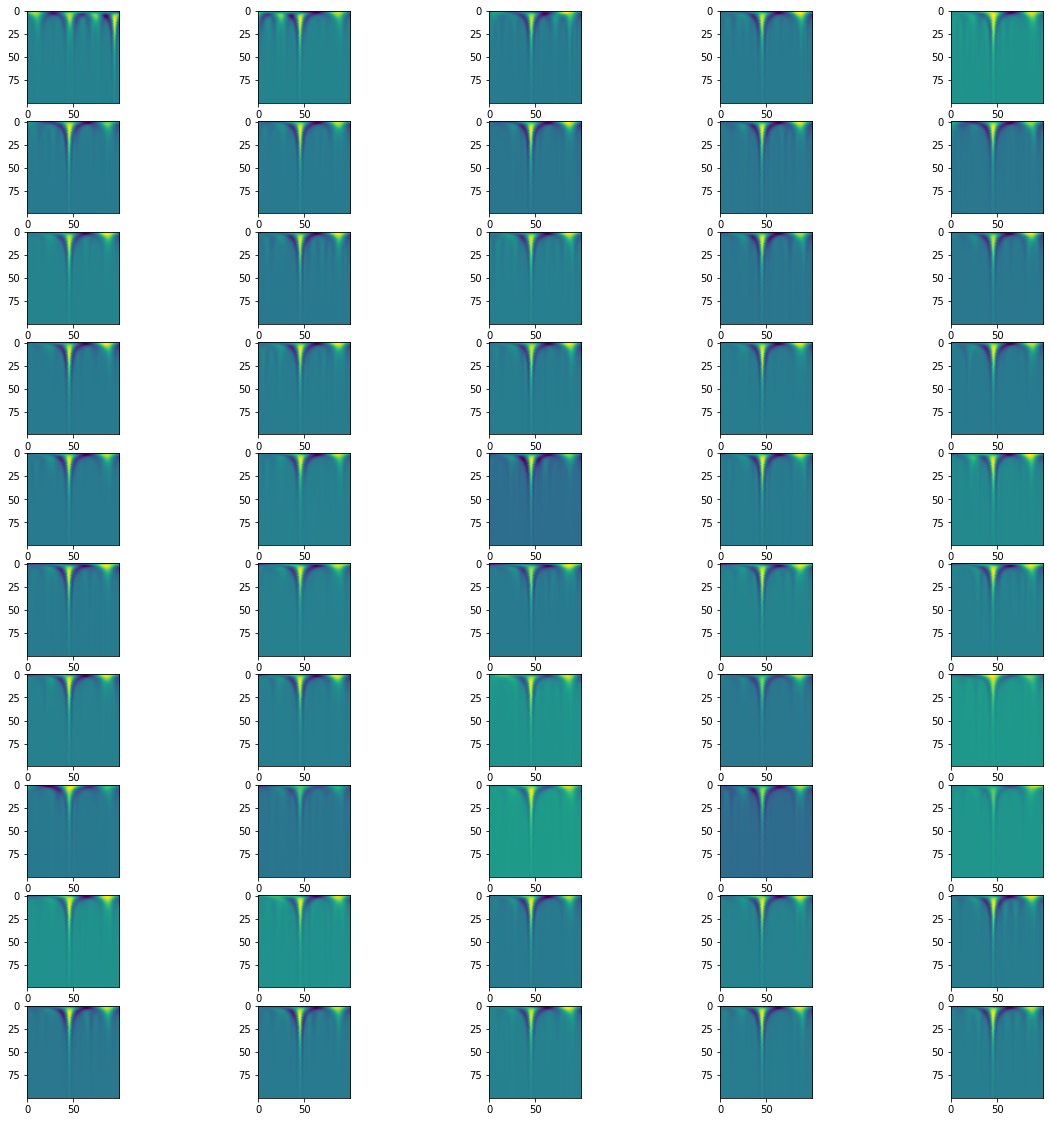

In [928]:
nrows=10
ncols=5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(x_cwt_train[i][0])

In [929]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 7)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.pooling1 = nn.MaxPool2d(5)
        self.pooling2 = nn.MaxPool2d(3)
        self.pooling3 = nn.AdaptiveMaxPool2d((1, 1))
        self.fc1 = nn.Linear(68, 32)
        self.fc2 = nn.Linear(32, 4)

    def forward(self, x1, x2):
        x1 = F.relu(self.bn1(self.conv1(x1)))  # (16 x 94 x 94)
        x1 = self.pooling1(x1)  # (16 x 18 x 18)
        x1 = F.relu(self.bn2(self.conv2(x1)))  # (32 x 16 x 16)
        x1 = self.pooling2(x1)  # (32 x 5 x 5)
        x1 = F.relu(self.bn3(self.conv3(x1)))  # (64 x 3 x 3)
        x1 = self.pooling3(x1)  # (64 x 1 x 1)
        x1 = x1.view((-1, 64))  # (64,)
        x = torch.cat((x1, x2), dim=1)  # (68,)
        x = F.relu(self.fc1(x))  # (32,)
        x = self.fc2(x)  # (4,)
        return x

In [930]:
class_weights = torch.tensor([3030, 443, 1474, 170]) / 5117
class_weights

tensor([0.5921, 0.0866, 0.2881, 0.0332])

In [931]:
callbacks = [
    Initializer("[conv|fc]*.weight", fn=torch.nn.init.kaiming_normal_),
    Initializer("[conv|fc]*.bias", fn=partial(torch.nn.init.constant_, val=0.0)),
    LRScheduler(policy=StepLR, step_size=5, gamma=0.1),
    EpochScoring(scoring=make_scorer(f1_score, average="macro"), lower_is_better=False, name="valid_f1"),
    #TensorBoard(SummaryWriter(log_dir))
]
net = NeuralNetClassifier(  # skorch is extensive package of pytorch for compatible with scikit-learn
    MyModule,
    criterion=torch.nn.CrossEntropyLoss(weight=class_weights),
    optimizer=torch.optim.Adam,
    lr=0.001,
    max_epochs=30,
    batch_size=1024,
    #train_split=predefined_split(Dataset({"x1": x1_test, "x2": x2_test}, y_test)),
    verbose=1,
    #device="cuda",
    callbacks=callbacks,
    #iterator_train__shuffle=True,
    optimizer__weight_decay=0,
)

In [932]:
net.fit({'x1': x_cwt_train, 'x2': x_rr_train}, y_train)

  epoch    train_loss    valid_acc    valid_f1    valid_loss      lr       dur
-------  ------------  -----------  ----------  ------------  ------  --------
      1        0.6953       0.5816      0.2339        0.5937  0.0010  540.7377
      2        0.5775       0.5915      0.2485        0.5737  0.0010  525.9180
      3        0.5608       0.5910      0.2505        0.5650  0.0010  526.4684
      4        0.5492       0.5963      0.2613        0.5560  0.0010  527.9139
      5        0.5406       0.6011      0.2681        0.5529  0.0010  541.1137
      6        0.5233       0.6172      0.2940        0.5398  0.0001  540.3896
      7        0.5177       0.6175      0.2947        0.5389  0.0001  537.4981
      8        0.5160       0.6173      0.2955        0.5385  0.0001  536.4876
      9        0.5147       0.6172      0.2953        0.5382  0.0001  538.6314
     10        0.5135       0.6169      0.2948        0.5378  0.0001  535.3822
     11        0.5102       0.6176      0.2962      

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=MyModule(
    (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pooling1): MaxPool2d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
    (pooling2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (pooling3): AdaptiveMaxPool2d(output_size=(1, 1))
    (fc1): Linear(in_features=68, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=4, bias=True)
  ),
)